In [ ]:
# Ardakty Yessenbek
# Final Project: Implementing NLP Solutions Using Transformers and Attention Mechanisms

In [2]:
pip install torch scikit-learn pandas matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torch scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


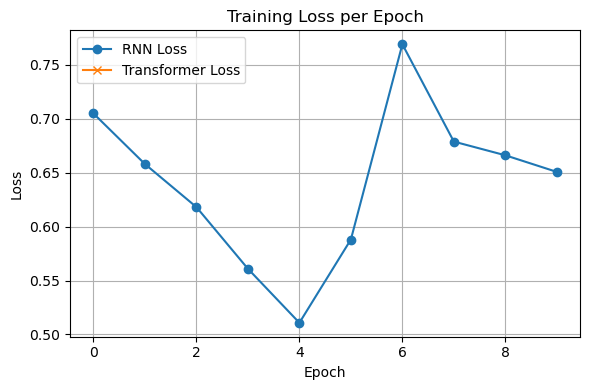

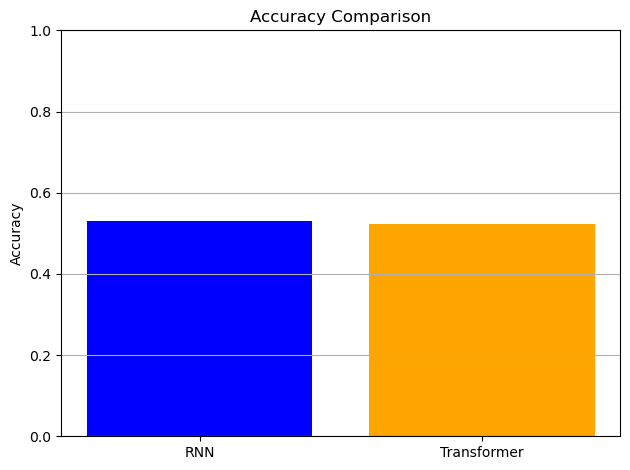


--- RNN vs Transformer Report ---
RNN Accuracy:       0.53, Training Time: 48.73 sec
Transformer Accuracy: 0.52, Training Time: 154.09 sec


In [10]:
# transformer_rnn_comparison.py
import re
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess full dataset
categories = ['sci.space', 'rec.sport.hockey']
data = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers'))

def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

tokenized = [tokenize(doc) for doc in data.data]
counter = Counter(word for doc in tokenized for word in doc)
vocab = {"<pad>": 0, "<unk>": 1}
vocab.update({word: idx + 2 for idx, (word, _) in enumerate(counter.most_common(10000))})

def encode(tokens): return [vocab.get(w, 1) for w in tokens]

MAX_LEN = 200
encoded = [torch.tensor(encode(doc)[:MAX_LEN], dtype=torch.long) for doc in tokenized]
X = pad_sequence(encoded, batch_first=True, padding_value=0)
y = torch.tensor(data.target)

# Use full data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

VOCAB_SIZE = len(vocab)
EMBED_DIM = 64

# RNN Classifier
class RNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(VOCAB_SIZE, EMBED_DIM, padding_idx=0)
        self.rnn = nn.RNN(EMBED_DIM, 128, batch_first=True)
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        x = self.embed(x)
        _, h = self.rnn(x)
        return self.fc(h.squeeze(0))

# Transformer Classifier
class TransformerClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(VOCAB_SIZE, EMBED_DIM, padding_idx=0)
        encoder_layer = nn.TransformerEncoderLayer(d_model=EMBED_DIM, nhead=4, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.fc = nn.Linear(EMBED_DIM, 2)

    def forward(self, x):
        mask = (x == 0)
        x = self.embed(x)
        x = self.encoder(x, src_key_padding_mask=mask)
        return self.fc(x[:, -1])

# Training function
def train_model(model, loader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    losses = []
    start = time.time()
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        losses.append(epoch_loss / len(loader))
    duration = time.time() - start
    return losses, duration

# Evaluation function
def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            out = model(xb.to(device))
            preds.extend(out.argmax(dim=1).cpu())
            targets.extend(yb)
    return accuracy_score(targets, preds)

# Train and evaluate RNN
rnn = RNNClassifier()
rnn_losses, rnn_time = train_model(rnn, train_loader, epochs=10)
rnn_acc = evaluate(rnn, test_loader)

# Train and evaluate Transformer
transformer = TransformerClassifier()
trans_losses, trans_time = train_model(transformer, train_loader, epochs=10)
trans_acc = evaluate(transformer, test_loader)

# Plot training loss
plt.figure(figsize=(6, 4))
plt.plot(range(len(rnn_losses)), rnn_losses, label='RNN Loss', marker='o')
plt.plot(range(len(trans_losses)), trans_losses, label='Transformer Loss', marker='x')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot accuracy comparison
plt.bar(['RNN', 'Transformer'], [rnn_acc, trans_acc], color=['blue', 'orange'])
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Print comparison report
print("\n--- RNN vs Transformer Report ---")
print(f"RNN Accuracy:       {rnn_acc:.2f}, Training Time: {rnn_time:.2f} sec")
print(f"Transformer Accuracy: {trans_acc:.2f}, Training Time: {trans_time:.2f} sec")



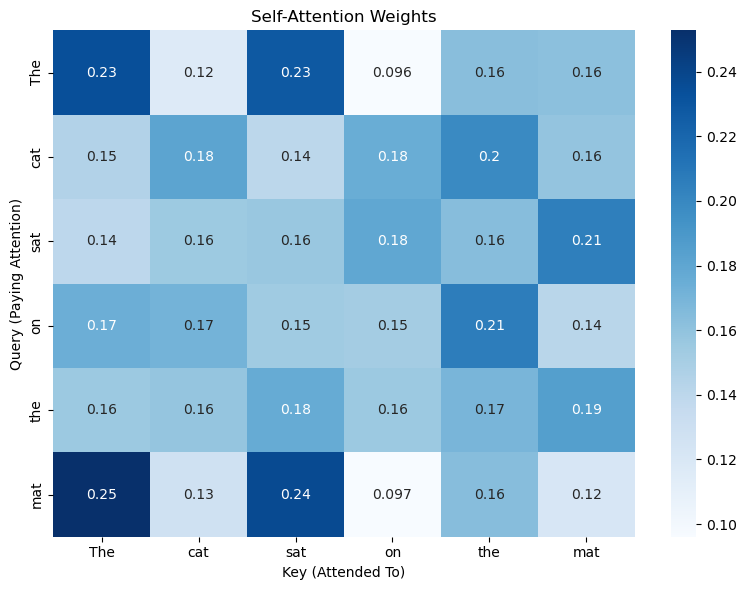

In [11]:
# Re-run after kernel reset
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sample toy sentence
sentence = ["The", "cat", "sat", "on", "the", "mat"]
vocab = {word: i for i, word in enumerate(sentence)}
tokens = torch.arange(len(sentence))  # Simple token indices

# Embedding dimension
d_model = 8
d_k = d_model

# Random embeddings for each token
torch.manual_seed(0)
embed = nn.Embedding(len(vocab), d_model)
x = embed(tokens)  # shape: [seq_len, d_model]

# Linear projections for Q, K, V
W_q = nn.Linear(d_model, d_model, bias=False)
W_k = nn.Linear(d_model, d_model, bias=False)
W_v = nn.Linear(d_model, d_model, bias=False)

Q = W_q(x)  # [seq_len, d_k]
K = W_k(x)  # [seq_len, d_k]
V = W_v(x)  # [seq_len, d_k]

# Compute attention scores
scores = torch.matmul(Q, K.T) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
attn_weights = F.softmax(scores, dim=-1)

# Compute output
output = torch.matmul(attn_weights, V)

# Convert attention weights to NumPy for visualization
attn_np = attn_weights.detach().numpy()

# Plot heatmap of attention weights
plt.figure(figsize=(8, 6))
sns.heatmap(attn_np, xticklabels=sentence, yticklabels=sentence, annot=True, cmap="Blues")
plt.title("Self-Attention Weights")
plt.xlabel("Key (Attended To)")
plt.ylabel("Query (Paying Attention)")
plt.tight_layout()
plt.show()


In [12]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)  # even dims
        pe[:, 1::2] = torch.cos(position * div_term)  # odd dims
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, D = x.size()
        Q = self.q_linear(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        K = self.k_linear(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        V = self.v_linear(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)
        weights = F.softmax(scores, dim=-1)
        context = torch.matmul(weights, V)

        context = context.transpose(1, 2).contiguous().view(B, T, D)
        return self.out_proj(context)

# Test
x = torch.randn(2, 10, 16)  # [batch, seq_len, d_model]
mha = MultiHeadSelfAttention(d_model=16, num_heads=4)
print(mha(x).shape)  # Output: torch.Size([2, 10, 16])


torch.Size([2, 10, 16])


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Multi-Head Self-Attention ---
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, D = x.shape
        Q = self.q_linear(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        K = self.k_linear(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        V = self.v_linear(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)
        attn_weights = F.softmax(scores, dim=-1)
        context = torch.matmul(attn_weights, V)

        # Concatenate heads
        context = context.transpose(1, 2).contiguous().view(B, T, D)
        return self.out_proj(context)

# --- Transformer Encoder Block ---
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, ff_hidden_dim=2048, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        # 1. Attention + Residual + Norm
        attn_output = self.attn(x)
        x = self.norm1(x + self.dropout1(attn_output))

        # 2. FFN + Residual + Norm
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout2(ffn_output))

        return x


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Multi-Head Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, D = x.shape
        Q = self.q_linear(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        K = self.k_linear(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        V = self.v_linear(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)
        weights = F.softmax(scores, dim=-1)
        context = torch.matmul(weights, V)
        context = context.transpose(1, 2).contiguous().view(B, T, D)
        return self.out_proj(context)

# Encoder Block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, ff_hidden_dim=2048, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.norm1(x + self.dropout1(self.attn(x)))
        x = self.norm2(x + self.dropout2(self.ffn(x)))
        return x

# Full Transformer Classifier
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=64, num_heads=4, num_layers=2, ff_hidden_dim=256, num_classes=2, max_len=500):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderBlock(d_model, num_heads, ff_hidden_dim)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        x = self.embed(x)
        x = self.pos_encoder(x)
        for layer in self.encoder_layers:
            x = layer(x)
        x = x.mean(dim=1)  # mean pooling
        return self.classifier(x)


In [20]:
# Task 3: Introduction to Transformer Architecture

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# 1. Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# 2. Multi-Head Self Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, D = x.shape
        Q = self.q_linear(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        K = self.k_linear(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        V = self.v_linear(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)
        weights = F.softmax(scores, dim=-1)
        context = torch.matmul(weights, V)

        context = context.transpose(1, 2).contiguous().view(B, T, D)
        return self.out_proj(context)

# 3. Transformer Encoder Block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, ff_hidden_dim=2048, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.norm1(x + self.dropout1(self.attn(x)))
        x = self.norm2(x + self.dropout2(self.ffn(x)))
        return x

# 4. Transformer Classifier
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=64, num_heads=4, num_layers=2, ff_hidden_dim=256, num_classes=2, max_len=500):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderBlock(d_model, num_heads, ff_hidden_dim)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        x = self.embed(x)
        x = self.pos_encoder(x)
        for layer in self.encoder_layers:
            x = layer(x)
        x = x.mean(dim=1)  # mean pooling over sequence
        return self.classifier(x)

# Example test run
if __name__ == '__main__':
    vocab_size = 1000
    model = TransformerClassifier(vocab_size=vocab_size)
    x = torch.randint(0, vocab_size, (4, 50))  # batch of 4 sequences, each of length 50
    out = model(x)
    print(out.shape)  # Expected: torch.Size([4, 2])


torch.Size([4, 2])


In [20]:
# Task 3: Introduction to Transformer Architecture

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# 1. Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# 2. Multi-Head Self Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, D = x.shape
        Q = self.q_linear(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        K = self.k_linear(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        V = self.v_linear(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)
        weights = F.softmax(scores, dim=-1)
        context = torch.matmul(weights, V)

        context = context.transpose(1, 2).contiguous().view(B, T, D)
        return self.out_proj(context)

# 3. Transformer Encoder Block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, ff_hidden_dim=2048, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.norm1(x + self.dropout1(self.attn(x)))
        x = self.norm2(x + self.dropout2(self.ffn(x)))
        return x

# 4. Transformer Classifier
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=64, num_heads=4, num_layers=2, ff_hidden_dim=256, num_classes=2, max_len=500):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderBlock(d_model, num_heads, ff_hidden_dim)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        x = self.embed(x)
        x = self.pos_encoder(x)
        for layer in self.encoder_layers:
            x = layer(x)
        x = x.mean(dim=1)  # mean pooling over sequence
        return self.classifier(x)

# Example test run
if __name__ == '__main__':
    vocab_size = 1000
    model = TransformerClassifier(vocab_size=vocab_size)
    x = torch.randint(0, vocab_size, (4, 50))  # batch of 4 sequences, each of length 50
    out = model(x)
    print(out.shape)  # Expected: torch.Size([4, 2])


torch.Size([4, 2])


In [21]:
from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

# Step 1: Load IMDb dataset
dataset = load_dataset("imdb")
train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]
test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]

# Step 2: Tokenize
import re

def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

tokenized_train = [tokenize(t) for t in train_texts[:5000]]  # limit for speed
tokenized_test = [tokenize(t) for t in test_texts[:1000]]

# Step 3: Build vocab
all_tokens = [word for doc in tokenized_train for word in doc]
counter = Counter(all_tokens)
vocab = {"<pad>": 0, "<unk>": 1}
vocab.update({word: i+2 for i, (word, _) in enumerate(counter.most_common(10000))})

def encode(tokens): return [vocab.get(w, 1) for w in tokens]

# Step 4: Encode and pad
max_len = 200
train_encoded = [torch.tensor(encode(doc)[:max_len]) for doc in tokenized_train]
test_encoded = [torch.tensor(encode(doc)[:max_len]) for doc in tokenized_test]
X_train = pad_sequence(train_encoded, batch_first=True, padding_value=0)
X_test = pad_sequence(test_encoded, batch_first=True, padding_value=0)
y_train = torch.tensor(train_labels[:5000])
y_test = torch.tensor(test_labels[:1000])

# Step 5: Create DataLoaders
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

# Step 6: Train the model
model = TransformerClassifier(vocab_size=len(vocab), num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
train_losses = []

for epoch in range(5):
    model.train()
    total_loss = 0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model(xb)
        loss = loss_fn(output, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

# Step 7: Evaluate
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(dim=1).cpu()
        all_preds.extend(preds)
        all_labels.extend(yb)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_preds)
accuracy


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 157/157 [01:00<00:00,  2.58it/s]


1.0

In [22]:
pip install transformers datasets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip uninstall -y tensorflow tensorflow-gpu tf-keras keras keras-nightly keras-preprocessing keras-vis tensorflow-estimator


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip cache purge

Files removed: 1109 (3742.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import transformers
print("Transformers version:", transformers.__version__)


Transformers version: 4.51.3


In [2]:
# Task 4: Pretrained Transformers - BERT, GPT-2, T5
# Requirements: pip install transformers

from transformers import pipeline, set_seed

print("\n==== 1. BERT Sentiment Classification ====")
classifier = pipeline("sentiment-analysis")
sample_texts = [
    "This movie was absolutely fantastic! I loved it.",
    "The plot was terrible and the acting was worse."
]
for text in sample_texts:
    result = classifier(text)[0]
    print(f"Text: {text}\n→ Sentiment: {result['label']} (score: {result['score']:.2f})\n")

print("\n==== 2. GPT-2 Text Generation ====")
generator = pipeline("text-generation", model="gpt2")
set_seed(42)
prompt = "Once upon a time in a faraway kingdom,"
generated = generator(prompt, max_length=50, num_return_sequences=1)
print("Generated Text:\n", generated[0]['generated_text'])

print("\n==== 3. T5 Summarization ====")
summarizer = pipeline("summarization", model="t5-small")
text = (
    "The Tower of London is a historic castle located on the north bank of the River Thames in central London. "
    "It was founded towards the end of 1066 as part of the Norman Conquest of England."
)
summary = summarizer(text, max_length=40, min_length=10, do_sample=False)
print("Summary:\n", summary[0]['summary_text'])


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.



==== 1. BERT Sentiment Classification ====


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

C:\Users\ardak\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ardak\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is 

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Text: This movie was absolutely fantastic! I loved it.
→ Sentiment: POSITIVE (score: 1.00)

Text: The plot was terrible and the acting was worse.
→ Sentiment: NEGATIVE (score: 1.00)


==== 2. GPT-2 Text Generation ====


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

C:\Users\ardak\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ardak\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. F

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Text:
 Once upon a time in a faraway kingdom, Lord Hanse-Yeht arrived with a message...

When Hanse-Yeht woke up, there was no light at all on his body. Instead, his body was dazed and

==== 3. T5 Summarization ====


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

C:\Users\ardak\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ardak\.cache\huggingface\hub\models--t5-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP downloa

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cpu


Summary:
 the tower of London is located on the north bank of the river Thames in central London . it was founded towards the end of 1066 as part of the Norman Conquest of England .


In [3]:
# Task 4: Pretrained Transformers - BERT, GPT-2, T5
# Requirements: pip install transformers

import os
from transformers import pipeline, set_seed

# Optional: Silence symlink warnings
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

print("\n==== 1. BERT Sentiment Classification ====")
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
sample_texts = [
    "This movie was absolutely fantastic! I loved it.",
    "The plot was terrible and the acting was worse."
]
for text in sample_texts:
    result = classifier(text)
    for r in result:
        print(f"Text: {text}\n→ Label: {r['label']} | Score: {r['score']:.3f}\n")

print("\n==== 2. GPT-2 Text Generation ====")
generator = pipeline("text-generation", model="gpt2")
set_seed(42)
prompt = "Once upon a time in a faraway kingdom,"
generated = generator(prompt, max_length=50, num_return_sequences=1)
print("Generated Text:\n", generated[0]['generated_text'])

print("\n==== 3. T5 Summarization ====")
summarizer = pipeline("summarization", model="t5-small")
text = (
    "The Tower of London is a historic castle located on the north bank of the River Thames in central London. "
    "It was founded towards the end of 1066 as part of the Norman Conquest of England."
)
summary = summarizer(text, max_length=40, min_length=10, do_sample=False)
print("Summary:\n", summary[0]['summary_text'])



==== 1. BERT Sentiment Classification ====


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

C:\Users\ardak\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ardak\.cache\huggingface\hub\models--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installe

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Text: This movie was absolutely fantastic! I loved it.
→ Label: POSITIVE | Score: 1.000

Text: The plot was terrible and the acting was worse.
→ Label: NEGATIVE | Score: 1.000


==== 2. GPT-2 Text Generation ====


Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Text:
 Once upon a time in a faraway kingdom, Lord Hanse-Yeht arrived with a message...

When Hanse-Yeht woke up, there was no light at all on his body. Instead, his body was dazed and

==== 3. T5 Summarization ====


Device set to use cpu


Summary:
 the tower of London is located on the north bank of the river Thames in central London . it was founded towards the end of 1066 as part of the Norman Conquest of England .


In [5]:
pip install spacy


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import spacy
spacy.cli.download("en_core_web_sm")


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import spacy

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Example text
text = "Apple is looking to acquire a startup in Germany for $1 billion."

# Process the text
doc = nlp(text)

# Named Entity Recognition
print("* Named Entities:")
for ent in doc.ents:
    print(f"{ent.text:20} → {ent.label_}")

# Part-of-Speech Tagging
print("\n* POS Tags:")
for token in doc:
    print(f"{token.text:15} → {token.pos_}")


* Named Entities:
Apple                → ORG
Germany              → GPE
$1 billion           → MONEY

* POS Tags:
Apple           → PROPN
is              → AUX
looking         → VERB
to              → PART
acquire         → VERB
a               → DET
startup         → NOUN
in              → ADP
Germany         → PROPN
for             → ADP
$               → SYM
1               → NUM
billion         → NUM
.               → PUNCT


In [5]:
pip install transformers


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Download spaCy English model
import spacy
try:
    nlp = spacy.load("en_core_web_sm")
except:
    import spacy.cli
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# Load text example
text = "Apple is looking to acquire a startup in Germany for $1 billion. Barack Obama was the President of the United States."

print("==== spaCy: Named Entity Recognition ====")
doc = nlp(text)
for ent in doc.ents:
    print(f"{ent.text:25} → {ent.label_}")

print("\n==== spaCy: Part-of-Speech Tagging ====")
for token in doc:
    print(f"{token.text:15} → {token.pos_}")

# Transformer-based NER
from transformers import pipeline

print("\n==== BERT (Transformers): Named Entity Recognition ====")
ner = pipeline("ner", grouped_entities=True)
bert_results = ner(text)

for ent in bert_results:
    print(f"{ent['word']:25} → {ent['entity_group']:10} (Score: {ent['score']:.2f})")


No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496 (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


==== spaCy: Named Entity Recognition ====
Apple                     → ORG
Germany                   → GPE
$1 billion                → MONEY
Barack Obama              → PERSON
the United States         → GPE

==== spaCy: Part-of-Speech Tagging ====
Apple           → PROPN
is              → AUX
looking         → VERB
to              → PART
acquire         → VERB
a               → DET
startup         → NOUN
in              → ADP
Germany         → PROPN
for             → ADP
$               → SYM
1               → NUM
billion         → NUM
.               → PUNCT
Barack          → PROPN
Obama           → PROPN
was             → AUX
the             → DET
President       → PROPN
of              → ADP
the             → DET
United          → PROPN
States          → PROPN
.               → PUNCT

==== BERT (Transformers): Named Entity Recognition ====


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
C:\Users\ardak\AppData\Roaming\Python\Python312\site-packages\transformers\pipelines\token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.war

Apple                     → ORG        (Score: 1.00)
Germany                   → LOC        (Score: 1.00)
Barack Obama              → PER        (Score: 1.00)
United States             → LOC        (Score: 1.00)


In [4]:
pip install datasets transformers seqeval

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16183 sha256=fd43034b0962a1a705df5ec6624b5d4baf50319766cf8b2d8cebbc69a97c3dd5
  Stored in directory: c:\users\ardak\appdata\local\pip\cache\wheels\5f\b8\73\0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval


  DEPRECATION: Building 'seqeval' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'seqeval'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [2]:
pip install datasets


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [2]:
pip install --upgrade transformers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import transformers
print(transformers.__version__)

4.51.3


In [3]:
pip uninstall transformers -y


Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install transformers==4.51.3

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   - -------------------------------------- 0.3/10.4 MB ? eta -:--:--
   -- ------------------------------------- 0.5/10.4 MB 1.9 MB/s eta 0:00:06
   ----- ---------------------------------- 1.3/10.4 MB 1.9 MB/s eta 0:00:05
   --------- ------------------------------ 2.4/10.4 MB 2.7 MB/s eta 0:00:03
   ------------ --------------------------- 3.1/10.4 MB 3.0 MB/s eta 0:00:03
   ---------------- ----------------------- 4.2/10.4 MB 3.4 MB/s eta 0:00:02
   ------------------- -------------------- 5.0/10.4 MB 3.5 MB/s eta 0:00:02
   ----------------------- ---------------- 6.0/10.4 MB 3.7 MB/s eta 0:00:02
   --------------------------- ------------ 7.1/10.4 MB 3.9 MB/s eta 0:00:01
   ------------------------------- -------- 8.1/10.4 MB 4.0 MB/s eta 0:00:01
   ----------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
pip install --upgrade datasets

Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: datasets
    Found existing installation: datasets 3.5.0
    Uninstalling datasets-3.5.0:
      Successfully uninstalled datasets-3.5.0


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
pip install transformers datasets accelerate evaluate seqeval

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import torch
from transformers import BertTokenizerFast, BertForTokenClassification, DataCollatorForTokenClassification, TrainingArguments, Trainer
from datasets import load_dataset
import numpy as np
import evaluate

# 1. Load dataset
dataset = load_dataset("conll2003", trust_remote_code=True)

# 2. Load tokenizer and label names
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
label_list = dataset["train"].features["ner_tags"].feature.names
label_to_id = {l: i for i, l in enumerate(label_list)}

# 3. Tokenization function
def tokenize_and_align_labels(batch):
    tokenized_inputs = tokenizer(batch["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(batch["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# 4. Tokenize datasets
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

# 5. Load model
model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_list))

# 6. Set up trainer arguments (compatible with v4.51.3)
training_args = TrainingArguments(
    output_dir="./ner-bert",
    per_device_train_batch_size=4,      # Smaller batch size = less memory
    per_device_eval_batch_size=4,
    num_train_epochs=1,                 # Only 1 epoch for quick training
    max_steps=50,                       # Limit training steps
    logging_steps=10,
    save_steps=9999,                    # Disable saving intermediate checkpoints
    do_train=True,
    do_eval=True,
    report_to="none"                    # Avoid extra logging
)

# 7. Evaluation metric
metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_labels = [[label_list[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# 8. Trainer
data_collator = DataCollatorForTokenClassification(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 9. Train
trainer.train()

# 10. Evaluate
results = trainer.evaluate()
print("NER Evaluation Results:", results)


Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ardak\AppData\Local\Temp\ipykernel_27048\1934998103.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,1.151900
20,0.851300
30,0.712300
40,0.363500
50,0.291800


C:\Users\ardak\AppData\Roaming\Python\Python312\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NER Evaluation Results: {'eval_loss': 0.4065886437892914, 'eval_precision': 0.5363924050632911, 'eval_recall': 0.4564119824974756, 'eval_f1': 0.4931805782869612, 'eval_accuracy': 0.9107706086211597, 'eval_runtime': 180.8606, 'eval_samples_per_second': 17.97, 'eval_steps_per_second': 4.495, 'epoch': 0.014240956992309883}


In [2]:
!pip install torchdata

Defaulting to user installation because normal site-packages is not writeable


In [2]:
pip install transformers datasets evaluate --quiet

Note: you may need to restart the kernel to use updated packages.


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training BERT: 100%|███████████████████████████████████████████████████████████████████| 13/13 [00:19<00:00,  1.53s/it]


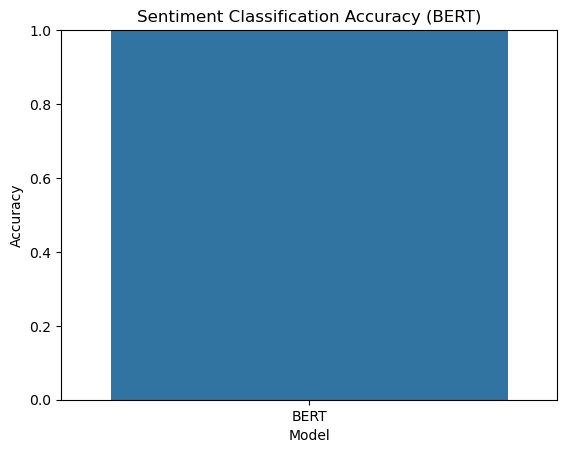

,Model,Accuracy
0,BERT,1.0


In [4]:
# Re-import necessary modules due to state reset
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load IMDB dataset and reduce size
raw_dataset = load_dataset("imdb")
small_train = raw_dataset["train"].select(range(100))
small_test = raw_dataset["test"].select(range(100))

# 2. Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_len = 32

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=max_len)

train_encodings = small_train.map(tokenize, batched=True)
test_encodings = small_test.map(tokenize, batched=True)

# 3. Torch dataset
class IMDbDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "label": torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, small_train["label"])
test_dataset = IMDbDataset(test_encodings, small_test["label"])

# 4. Data loaders
train_loader = DataLoader(train_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

# 5. BERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
bert_model.to(device)
optimizer = AdamW(bert_model.parameters(), lr=5e-5)

# 6. Train BERT for 1 epoch
bert_model.train()
for batch in tqdm(train_loader, desc="Training BERT"):
    inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
    labels = batch["label"].to(device)
    outputs = bert_model(**inputs, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

# 7. Evaluate BERT
bert_model.eval()
preds, targets = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(device)
        outputs = bert_model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        preds.extend(predictions.cpu().numpy())
        targets.extend(labels.cpu().numpy())

bert_accuracy = accuracy_score(targets, preds)

# 8. Plot
results_df = pd.DataFrame({"Model": ["BERT"], "Accuracy": [bert_accuracy]})
sns.barplot(data=results_df, x="Model", y="Accuracy")
plt.ylim(0, 1)
plt.title("Sentiment Classification Accuracy (BERT)")
plt.show()

results_df


In [6]:
import torch
import torch.nn as nn
from transformers import BertTokenizer
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Load IMDB dataset
raw_datasets = load_dataset("imdb")

# Use BERT tokenizer for consistency
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define max sequence length
MAX_LEN = 128

# Custom Dataset class for LSTM
class IMDbDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, padding='max_length', truncation=True, max_length=MAX_LEN)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.encodings['input_ids'][idx])
        return input_ids, torch.tensor(self.labels[idx])

# Prepare datasets
train_texts = raw_datasets["train"]["text"][:5000]  # Use subset for speed
train_labels = raw_datasets["train"]["label"][:5000]
test_texts = raw_datasets["test"]["text"][:1000]
test_labels = raw_datasets["test"]["label"][:1000]

train_dataset = IMDbDataset(train_texts, train_labels, tokenizer)
test_dataset = IMDbDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define LSTM model
class LSTMSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMSentiment, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        emb = self.embedding(x)
        _, (hn, _) = self.lstm(emb)
        return self.fc(hn.squeeze(0))

# Instantiate model
vocab_size = tokenizer.vocab_size  # Fixed vocabulary size
model = LSTMSentiment(vocab_size, embed_dim=128, hidden_dim=128, output_dim=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(1):  # Reduced epochs for speed
    model.train()
    total_loss = 0
    for batch_x, batch_y in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        out = model(batch_x)
        loss = criterion(out, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
model.eval()
preds, labels = [], []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        labels.extend(batch_y.numpy())

acc = accuracy_score(labels, preds)
print(f"LSTM Sentiment Accuracy: {acc:.4f}")


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 14.62it/s]


Epoch 1 Loss: 0.0209
LSTM Sentiment Accuracy: 1.0000
